# Baseline pretrained models

Systematically **evaluates transformer-based clinical NER** by benchmarking general and clinical-domain models. 

Pretrained Models
* `BERT`
* `DeBERTa`: Decoding-enhanced BERT with Disentangled Attention
* `Clinical-BERT`: Finetuned BERT by a large-scale corpus of EHRs from over 3 million patient records

In [1]:
# Utils
import pandas as pd
import numpy as np
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [2]:
# Model evaluation
from transformers import EvalPrediction
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score

# model and tokenizer
from transformers import AutoTokenizer, AutoModelForTokenClassification, DebertaForTokenClassification
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification
from transformers import Trainer, TrainingArguments

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
from prepare_dataset import prepare_data

In [5]:
data_dict = prepare_data("../processed_notes.csv")
data = data_dict["data"]
labels_to_ids = data_dict["labels_to_ids"]
ids_to_labels = data_dict["ids_to_labels"]

In [6]:
data.head()

,note_id,sentence_id,sentence,tags
0,10060142-DS-9,0,"[Name, :, Unit, No, :, Admission, Date, :, Dis...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,10060142-DS-9,1,"[Chief, Complaint, :, Biliary, pancreatitis, M...","[O, O, O, B-DISO, I-DISO, O, O, O, O, O, O, O,..."
2,10060142-DS-9,2,"[He, had, initially, had, multisystem, organ, ...","[O, O, O, O, B-DISO, I-DISO, I-DISO, O, O, B-D..."
3,10060142-DS-9,3,"[Mr., has, a, large, postnecrotic, pseudocyst,...","[O, O, O, O, O, B-DISO, O, O, O, O, B-PROC, O,..."
4,10060142-DS-9,4,"[He, has, some, debris, ,, but, this, is, not,...","[O, O, O, O, O, O, O, O, O, O, O, O]"


In [7]:
labels_to_ids

{'O': 0,
 'B-DISO': 1,
 'I-DISO': 2,
 'B-PROC': 3,
 'I-PROC': 4,
 'B-ANAT': 5,
 'I-ANAT': 6,
 'B-UNK': 7,
 'B-ACTI': 8,
 'I-ACTI': 9,
 'B-PHYS': 10,
 'I-PHYS': 11,
 'B-PHEN': 12,
 'I-PHEN': 13,
 'B-CONC': 14,
 'B-CHEM': 15,
 'I-CONC': 16,
 'B-OBJC': 17,
 'I-UNK': 18,
 'B-DEVI': 19,
 'I-DEVI': 20,
 'B-LIVB': 21,
 'I-LIVB': 22}

In [6]:
class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        # sentence = self.data.sentence[index].strip().split()
        # word_labels = self.data.tags[index].split(",")
        sentence = self.data.sentence[index]
        word_labels = self.data.tags[index]

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                            #  is_pretokenized=True,
                             is_split_into_words=True,
                             return_offsets_mapping=True,
                             padding='max_length',
                             truncation=True,
                             max_length=self.max_len)

        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [labels_to_ids[label] for label in word_labels]
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
              if i < len(labels):  # avoid IndexError
                # overwrite label
                encoded_labels[idx] = labels[i]
                i += 1
        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)

        return item

  def __len__(self):
        return self.len

In [7]:
def compute_metrics(p: EvalPrediction):
    predictions = p.predictions
    labels = p.label_ids

    # Get the class with highest probability for each token
    predicted_ids = np.argmax(predictions, axis=-1)

    true_labels = []
    true_predictions = []

    for pred, label in zip(predicted_ids, labels):
        curr_preds = []
        curr_labels = []
        for p_id, l_id in zip(pred, label):
            if l_id != -100:
                curr_preds.append(ids_to_labels[p_id])  # predicted label string
                curr_labels.append(ids_to_labels[l_id])  # true label string
        true_predictions.append(curr_preds)
        true_labels.append(curr_labels)

    return {
        "accuracy": accuracy_score(true_labels, true_predictions),
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions)
    }

In [8]:
def plot_eval():
    log_history = trainer.state.log_history

    train_steps, train_loss = [], []
    eval_steps, eval_loss, f1s = [], [], []
    
    for entry in log_history:
        if "loss" in entry and "step" in entry:
            train_steps.append(entry["step"])
            train_loss.append(entry["loss"])
        if "eval_loss" in entry:
            eval_steps.append(entry["step"])
            eval_loss.append(entry["eval_loss"])
            f1s.append(entry.get("eval_f1", None))  # only if F1 was logged
    
    plt.figure(figsize=(12, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_steps, train_loss, label="Train Loss")
    plt.plot(eval_steps, eval_loss, label="Eval Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training vs. Validation Loss")
    plt.legend()
    
    # Plot F1
    plt.subplot(1, 2, 2)
    if f1s[0] is not None:
        plt.plot(eval_steps, f1s, label="Eval F1", color='green')
        plt.xlabel("Steps")
        plt.ylabel("F1 Score")
        plt.title("Evaluation F1 over Time")
        plt.legend()
    
    plt.tight_layout()

## BERT

In [16]:
MAX_LEN = 128
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [17]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (20305, 4)
TRAIN Dataset: (16244, 4)
TEST Dataset: (4061, 4)


In [18]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids)) # TODO: load model
model.to(device)

# freeze the parameters of the base model
for param in model.bert.parameters():
    param.requires_grad = False
    
model

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [20]:
training_args = TrainingArguments(
    output_dir='./results_frozen_bert',
    num_train_epochs=6,
    learning_rate=5e-4,          # Higher learning rate
    per_device_train_batch_size=16, # Larger batch size if GPU allows (small param count)
    per_device_eval_batch_size=16,
    warmup_steps=50,             # Shorter warm-up (optional)
    weight_decay=0.01,           # Regularization still useful
    logging_dir='./logs_frozen_bert',
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=100,
    seed=42,
    report_to="none",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_set,
    eval_dataset=testing_set,
    compute_metrics=compute_metrics,
)

trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.644400,0.631355,0.816718,0.398230,0.079325,0.132297
100,0.631700,0.554010,0.835833,0.342796,0.202216,0.254376
150,0.557900,0.522191,0.843081,0.391263,0.259381,0.311956
200,0.538600,0.502209,0.844676,0.382553,0.276631,0.321081
250,0.506800,0.487793,0.848840,0.407603,0.291614,0.339988
300,0.452800,0.476973,0.850390,0.426561,0.297658,0.350638
350,0.480800,0.467782,0.852654,0.425521,0.308612,0.357758
400,0.465100,0.460088,0.855602,0.416267,0.349282,0.379844
450,0.487100,0.453560,0.855708,0.421944,0.348149,0.381511
500,0.516400,0.450282,0.856863,0.418295,0.371947,0.393762


KeyboardInterrupt: 

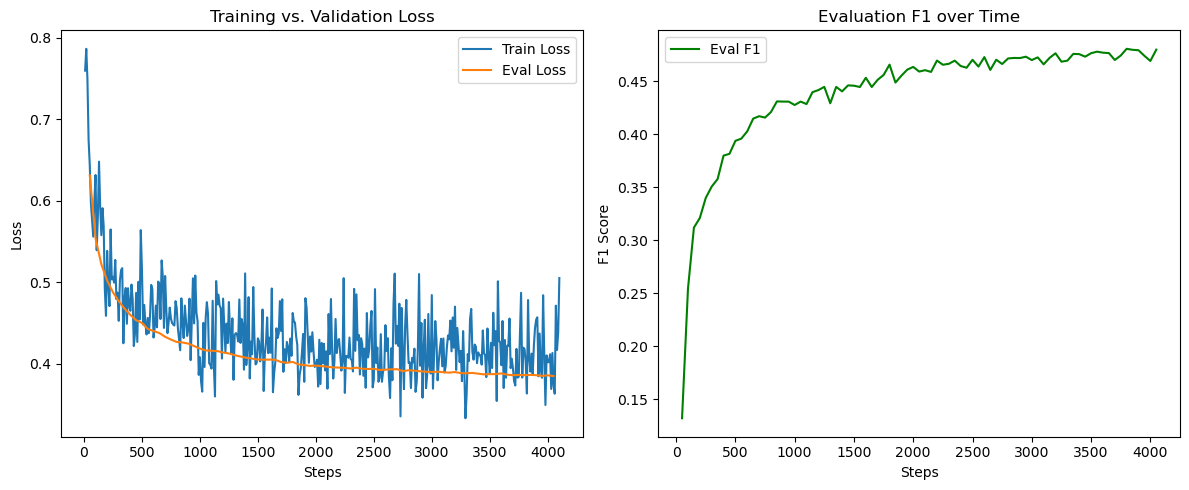

In [23]:
plot_eval()

## Clinical BERT

We previously used the ClinicalBERT by medicalai, which does have good results. Try [Bio_Clinical_BERT](https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT) in the next subsection. 

In [24]:
MODEL_NAME = "medicalai/ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) # TODO: add tokenizer

In [25]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (20305, 4)
TRAIN Dataset: (16244, 4)
TEST Dataset: (4061, 4)


In [26]:
model = BertForTokenClassification.from_pretrained(MODEL_NAME, num_labels=len(labels_to_ids)) # TODO: load model
model.to(device)

# freeze the parameters of the base model
for param in model.bert.parameters():
    param.requires_grad = False
    
model

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.att

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [27]:
training_args = TrainingArguments(
    output_dir='./results_frozen_clinical_bert',
    num_train_epochs=4,
    learning_rate=5e-4,          # Higher learning rate
    per_device_train_batch_size=16, # Larger batch size if GPU allows (small param count)
    per_device_eval_batch_size=16,
    warmup_steps=50,             # Shorter warm-up (optional)
    weight_decay=0.01,           # Regularization still useful
    logging_dir='./logs_frozen_clinical_bert',
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    seed=42,
    report_to="none",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_set,
    eval_dataset=testing_set,
    compute_metrics=compute_metrics,
)

trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.841300,0.763666,0.807873,0.000000,0.000000,0.000000
200,0.778200,0.725264,0.808102,0.193548,0.000764,0.001522
300,0.689700,0.722228,0.808239,0.169492,0.001273,0.002527
400,0.690500,0.709509,0.808591,0.168421,0.002037,0.004025
500,0.772100,0.688190,0.811264,0.209830,0.014131,0.026479
600,0.717400,0.685078,0.810928,0.209412,0.011330,0.021498
700,0.789200,0.672188,0.810882,0.199557,0.011458,0.021671
800,0.712400,0.697061,0.809140,0.120000,0.002292,0.004497
900,0.713600,0.680310,0.810118,0.160991,0.006620,0.012717
1000,0.673000,0.669894,0.811401,0.249485,0.015404,0.029017


/home/xc392/.conda/envs/clinical-ner/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=4064, training_loss=0.7086215343062333, metrics={'train_runtime': 288.4559, 'train_samples_per_second': 225.255, 'train_steps_per_second': 14.089, 'total_flos': 4245310376841216.0, 'train_loss': 0.7086215343062333, 'epoch': 4.0})

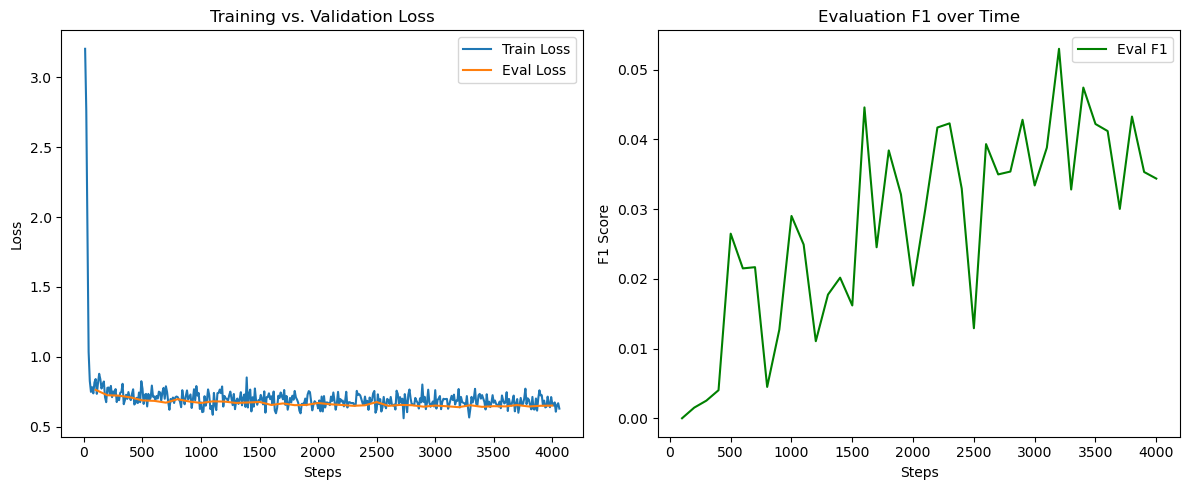

In [28]:
plot_eval()

#### Bio_ClinicalBERT

In [9]:
MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) # TODO: add tokenizer

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [11]:
MAX_LEN = 128

train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (20305, 4)
TRAIN Dataset: (16244, 4)
TEST Dataset: (4061, 4)


In [12]:
model = BertForTokenClassification.from_pretrained(MODEL_NAME, num_labels=len(labels_to_ids)) # TODO: load model
model.to(device)

# freeze the parameters of the base model
for param in model.bert.parameters():
    param.requires_grad = False
    
model

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [13]:
training_args = TrainingArguments(
    output_dir='./results_frozen_clinical_bert',
    num_train_epochs=4,
    learning_rate=5e-4,          # Higher learning rate
    per_device_train_batch_size=16, # Larger batch size if GPU allows (small param count)
    per_device_eval_batch_size=16,
    warmup_steps=50,             # Shorter warm-up (optional)
    weight_decay=0.01,           # Regularization still useful
    logging_dir='./logs_frozen_clinical_bert',
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    seed=42,
    report_to="none",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_set,
    eval_dataset=testing_set,
    compute_metrics=compute_metrics,
)

trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.724800,0.620501,0.816978,0.535622,0.079309,0.138160
200,0.524800,0.484787,0.849827,0.478154,0.296263,0.365848
300,0.443400,0.443665,0.860170,0.484817,0.355109,0.409948
400,0.422800,0.423148,0.867305,0.478705,0.417133,0.445803
500,0.457100,0.409821,0.870086,0.478036,0.446746,0.461862
600,0.392800,0.399063,0.873371,0.478289,0.468988,0.473593
700,0.450300,0.389659,0.875663,0.490813,0.471912,0.481177
800,0.424100,0.383390,0.875938,0.493855,0.474962,0.484224
900,0.415100,0.379975,0.876977,0.496343,0.491612,0.493966
1000,0.369600,0.374036,0.878673,0.508982,0.486146,0.497302


TrainOutput(global_step=4064, training_loss=0.41652764203980214, metrics={'train_runtime': 562.5688, 'train_samples_per_second': 115.499, 'train_steps_per_second': 7.224, 'total_flos': 4245310376841216.0, 'train_loss': 0.41652764203980214, 'epoch': 4.0})

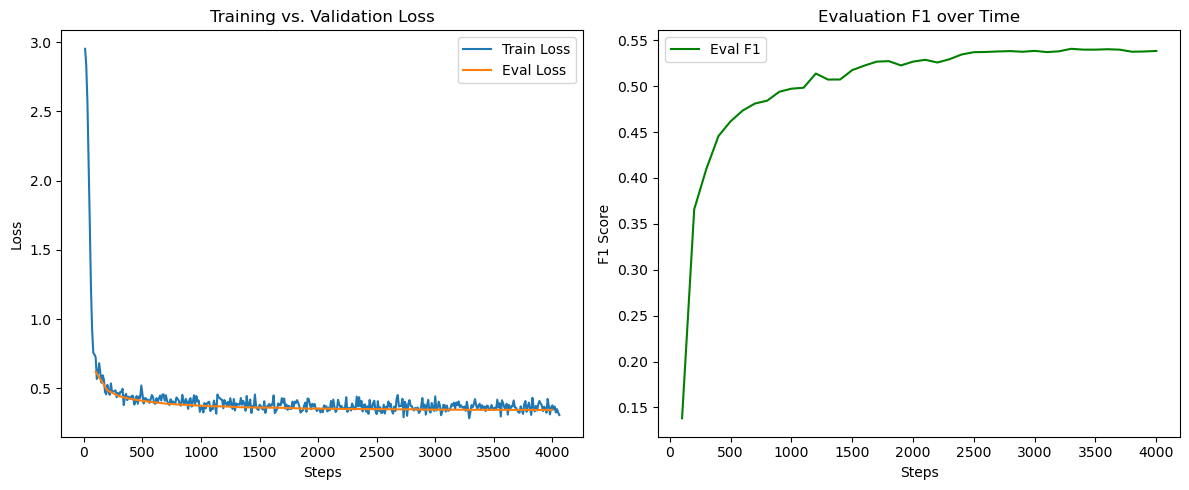

In [14]:
plot_eval()

## deBerta

In [7]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        sentence = self.data.sentence[index]
        word_labels = self.data.tags[index]

        encoding = self.tokenizer(sentence,
                                  is_split_into_words=True,
                                  padding='max_length',
                                  truncation=True,
                                  max_length=self.max_len)

        labels = [labels_to_ids[label] for label in word_labels]

        encoded_labels = np.ones(len(encoding["input_ids"]), dtype=int) * -100
        word_ids = encoding.word_ids()

        previous_word_idx = None
        for idx, word_idx in enumerate(word_ids):
            if word_idx is None:
                continue
            elif word_idx != previous_word_idx:
                encoded_labels[idx] = labels[word_idx]
            previous_word_idx = word_idx

        item = {key: torch.tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.tensor(encoded_labels)

        return item

    def __len__(self):
        return self.len

In [11]:
MAX_LEN=128
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base", add_prefix_space=True)

In [12]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (20305, 4)
TRAIN Dataset: (16244, 4)
TEST Dataset: (4061, 4)


In [13]:
model = DebertaForTokenClassification.from_pretrained("microsoft/deberta-base", num_labels=len(labels_to_ids))
model.to(device)

# freeze the parameters of the base model
for param in model.deberta.parameters():
    param.requires_grad = False
    
model

Some weights of DebertaForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaForTokenClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): Dropout(p=0.1,

In [18]:
training_args = TrainingArguments(
    num_train_epochs=4,
    learning_rate=1e-4, # Lower learning rate
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=50,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    seed=42,
    report_to="none",
    bf16=False,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_set,
    eval_dataset=testing_set,
    compute_metrics=compute_metrics,
)

trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.463000,0.387389,0.874110,0.511898,0.456659,0.482703
200,0.417800,0.385236,0.874353,0.516854,0.459186,0.486316
300,0.378600,0.384120,0.874840,0.511970,0.462092,0.485754
400,0.393000,0.382317,0.875114,0.508637,0.468789,0.487901
500,0.441800,0.381100,0.875114,0.514302,0.463482,0.487571
600,0.377600,0.379814,0.875297,0.511844,0.466894,0.488337
700,0.435400,0.378693,0.875814,0.513458,0.470053,0.490798
800,0.437800,0.377532,0.875647,0.515556,0.469042,0.491200
900,0.413200,0.376576,0.876499,0.510553,0.482942,0.496364
1000,0.374200,0.375166,0.876758,0.516322,0.479656,0.497314


TrainOutput(global_step=4064, training_loss=0.394075705897151, metrics={'train_runtime': 764.0744, 'train_samples_per_second': 85.039, 'train_steps_per_second': 5.319, 'total_flos': 4951705795497984.0, 'train_loss': 0.394075705897151, 'epoch': 4.0})

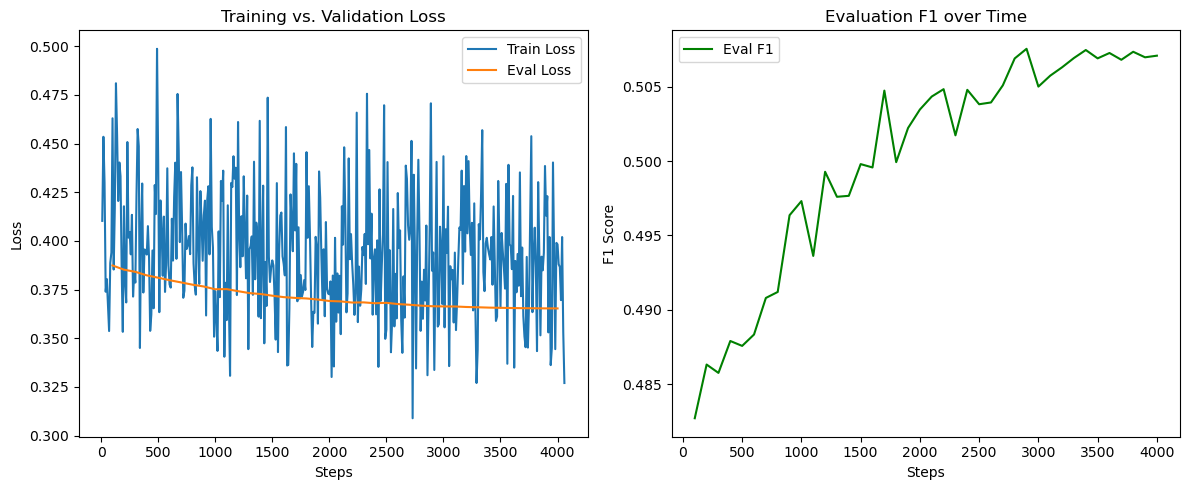

In [19]:
plot_eval()